## Image网 Submission `128x128`

This contains a submission for the Image网 leaderboard in the `128x128` category.

In this notebook we:
1. Train on 1 pretext task: 
  - Train a network to do image inpatining on Image网's `/train`, `/unsup` and `/val` images. 
2. Train on 4 downstream tasks:
  - We load the pretext weights and train for `5` epochs.
  - We load the pretext weights and train for `20` epochs.
  - We load the pretext weights and train for `80` epochs.
  - We load the pretext weights and train for `200` epochs.
  
Our leaderboard submissions are the accuracies we get on each of the downstream tasks.

In [1]:
import json
import torch

import numpy as np

from functools import partial

from fastai2.layers import Mish, MaxPool, LabelSmoothingCrossEntropy
from fastai2.learner import Learner
from fastai2.metrics import accuracy, top_k_accuracy
from fastai2.basics import DataBlock, RandomSplitter, GrandparentSplitter, CategoryBlock

from fastai2.optimizer import ranger, Adam, SGD, RMSProp

from fastai2.vision.all import *
from fastai2.vision.core import *
from fastai2.vision.augment import *
from fastai2.vision.learner import unet_learner, unet_config
from fastai2.vision.models.xresnet import xresnet50, xresnet34

from fastai2.data.transforms import Normalize, parent_label
from fastai2.data.external import download_url, URLs, untar_data


from fastcore.utils import num_cpus

from torch.nn import MSELoss
from torchvision.models import resnet34

In [2]:
torch.cuda.set_device(6)

## Pretext Task: Image Inpainting

In [3]:
# Chosen parameters
lr=8e-3
sqrmom=0.99
mom=0.95
beta=0.
eps=1e-6
bs=64 
opt='ranger'
sa=1
fp16=1
pool='MaxPool'
sym=0

# NOTE: Normally loaded from their corresponding string
m = xresnet18
act_fn = Mish
pool = MaxPool

nc=20

In [4]:
source = untar_data(URLs.IMAGEWANG_160)
len(get_image_files(source/'unsup')), len(get_image_files(source/'train'))

(7750, 14669)

In [5]:
# [s.name for s in (source/'train').ls()], [s.name for s in (source/'val').ls()]

In [6]:
def get_dbunch(size, bs, workers=8):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    files = get_image_files(source)
    
    tfms = [[PILImage.create, ToTensor, Resize(size)], 
            [lambda x: x.parent.name, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    dls.path = source
    return dls

In [7]:
# Use the Ranger optimizer
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [8]:
size = 128
bs = 128

dbunch = get_dbunch(160, bs)
dbunch.c = nc

In [9]:
len(dbunch.train.dataset)

23714

In [10]:
xb,yb = dbunch.one_batch()
xb.shape, yb.shape

(torch.Size([128, 3, 160, 160]), torch.Size([128]))

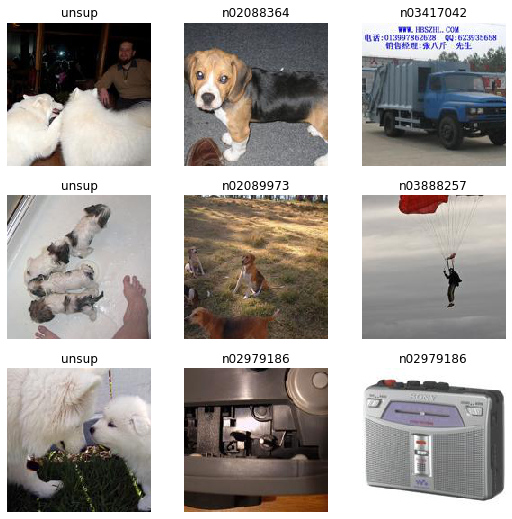

In [11]:
dbunch.show_batch()

In [12]:

from rsna_retro.self_supervised import *
from rsna_retro.contrastive_loss import *

Loading imports


In [13]:
m_part = partial(m, c_out=nc, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool)

In [14]:
ss_name = 'imagewang_contrast_ss1'

In [15]:
aug = get_aug_pipe(size, min_scale=0.35, mult=1, stats=imagenet_stats)
aug2 = get_aug_pipe(size, min_scale=0.3, mult=2, stats=imagenet_stats)
cbs = SSCallback(XentLoss(0.1), size=size, aug_targ=aug, aug_pos=aug2, multi_loss=False)
# cbs = SSCallback(BatchContrastiveLoss(XentLoss(0.1)), size=size, aug_targ=aug, aug_pos=aug2, multi_loss=False)


ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 1024), nn.ReLU(), nn.Linear(1024, 64))
learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                    metrics=[], loss_func=CrossEntropyLossFlat(), cbs=cbs,
                    config={'custom_head':ch}, pretrained=False,
                   )
#         metrics=[], loss_func=LabelSmoothingCrossEntropy())

In [20]:
learn.unfreeze()
learn.fit_flat_cos(30, 4e-2, wd=1e-3)

epoch,train_loss,valid_loss,time
0,0.528368,0.739715,00:34
1,0.409726,0.732199,00:33
2,0.299814,0.662773,00:33
3,0.285287,0.565084,00:33
4,0.255629,0.295358,00:33
5,0.210083,0.405109,00:34
6,0.190327,0.394789,00:33
7,0.189951,0.280144,00:33
8,0.192120,0.333306,00:33
9,0.167614,0.294776,00:33


In [21]:
learn.save(ss_name)

## Visualizing what it does

In [33]:
learn.load('imagewang_contrast_ss2')

In [34]:
xb,yb = dbunch.one_batch()

In [35]:
xb

TensorImage([[[[0.3255, 0.3725, 0.9412,  ..., 0.9529, 0.9765, 0.9922],
          [0.4510, 0.6549, 0.8314,  ..., 0.9529, 0.9765, 0.9922],
          [0.9137, 0.8706, 0.9373,  ..., 0.9804, 0.9882, 0.9765],
          ...,
          [0.9686, 0.3020, 0.1059,  ..., 0.2863, 0.2784, 0.6078],
          [0.9765, 0.3059, 0.1059,  ..., 0.2745, 0.2667, 0.5961],
          [0.9804, 0.3098, 0.1098,  ..., 0.2588, 0.2510, 0.5804]],

         [[0.3255, 0.3686, 0.9373,  ..., 0.9686, 0.9843, 1.0000],
          [0.4549, 0.6588, 0.8353,  ..., 0.9686, 0.9843, 1.0000],
          [0.9137, 0.8706, 0.9373,  ..., 0.9961, 0.9961, 0.9843],
          ...,
          [0.9451, 0.2784, 0.0824,  ..., 0.2275, 0.2196, 0.5490],
          [0.9529, 0.2824, 0.0824,  ..., 0.2157, 0.2078, 0.5373],
          [0.9569, 0.2863, 0.0863,  ..., 0.2078, 0.2000, 0.5294]],

         [[0.2314, 0.2863, 0.8588,  ..., 0.9647, 0.9804, 0.9961],
          [0.3843, 0.5961, 0.7804,  ..., 0.9647, 0.9804, 0.9961],
          [0.8667, 0.8235, 0.8980,  .

In [36]:
targ = aug(xb)
pos = aug2(xb)

In [37]:
nrm = Normalize.from_stats(*imagenet_stats)

In [38]:
xb

TensorImage([[[[0.3255, 0.3725, 0.9412,  ..., 0.9529, 0.9765, 0.9922],
          [0.4510, 0.6549, 0.8314,  ..., 0.9529, 0.9765, 0.9922],
          [0.9137, 0.8706, 0.9373,  ..., 0.9804, 0.9882, 0.9765],
          ...,
          [0.9686, 0.3020, 0.1059,  ..., 0.2863, 0.2784, 0.6078],
          [0.9765, 0.3059, 0.1059,  ..., 0.2745, 0.2667, 0.5961],
          [0.9804, 0.3098, 0.1098,  ..., 0.2588, 0.2510, 0.5804]],

         [[0.3255, 0.3686, 0.9373,  ..., 0.9686, 0.9843, 1.0000],
          [0.4549, 0.6588, 0.8353,  ..., 0.9686, 0.9843, 1.0000],
          [0.9137, 0.8706, 0.9373,  ..., 0.9961, 0.9961, 0.9843],
          ...,
          [0.9451, 0.2784, 0.0824,  ..., 0.2275, 0.2196, 0.5490],
          [0.9529, 0.2824, 0.0824,  ..., 0.2157, 0.2078, 0.5373],
          [0.9569, 0.2863, 0.0863,  ..., 0.2078, 0.2000, 0.5294]],

         [[0.2314, 0.2863, 0.8588,  ..., 0.9647, 0.9804, 0.9961],
          [0.3843, 0.5961, 0.7804,  ..., 0.9647, 0.9804, 0.9961],
          [0.8667, 0.8235, 0.8980,  .

In [39]:
nrm(xb).std()

TensorImage(1.2094, device='cuda:6')

In [40]:
aug(xb)

TensorImage([[[[-1.1976, -1.1998, -1.1509,  ...,  2.2189,  2.1954,  2.1711],
          [-1.1236, -1.1336, -1.1530,  ...,  2.2091,  2.1757,  2.1251],
          [-1.1770, -1.2255, -1.1873,  ...,  2.2177,  2.2188,  2.2106],
          ...,
          [-1.5339, -1.5526, -1.5264,  ..., -1.6076, -1.1972, -0.8022],
          [-1.6795, -1.5544, -1.4582,  ..., -1.4983, -0.8733, -0.6266],
          [-1.7807, -1.5582, -1.2898,  ..., -1.2828, -0.6470, -0.5768]],

         [[-1.2141, -1.2141, -1.1578,  ...,  2.4235,  2.4088,  2.3841],
          [-1.1538, -1.1617, -1.1735,  ...,  2.4149,  2.3859,  2.3363],
          [-1.1327, -1.1980, -1.1699,  ...,  2.4229,  2.4201,  2.4102],
          ...,
          [-1.6229, -1.6426, -1.6069,  ..., -1.6298, -1.1981, -0.7870],
          [-1.7651, -1.6360, -1.5242,  ..., -1.5327, -0.8872, -0.6337],
          [-1.8661, -1.6379, -1.3499,  ..., -1.3045, -0.6548, -0.5830]],

         [[-1.1400, -1.1475, -1.1420,  ...,  2.6269,  2.6029,  2.5783],
          [-1.0024, -1.01

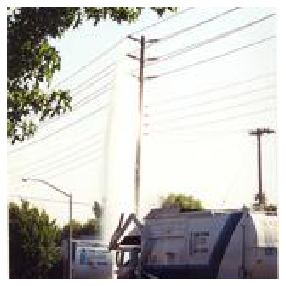

In [41]:
show_image(xb[0])

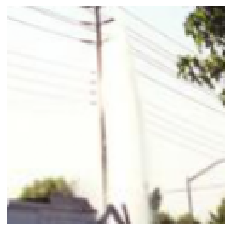

In [42]:
show_image(nrm.decode(targ)[0])

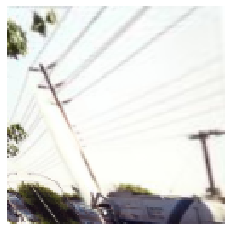

In [43]:
show_image(nrm.decode(pos)[0])

In [44]:
stack = torch.cat((targ,pos),dim=0)

In [45]:
with torch.no_grad():
    out = learn.model(stack)

In [46]:
F.cosine_similarity(out[:128], out[128:])

tensor([0.7690, 0.8946, 0.7459, 0.9511, 0.8948, 0.9668, 0.8718, 0.8679, 0.9116,
        0.9452, 0.9185, 0.7917, 0.9268, 0.9185, 0.9637, 0.8210, 0.8683, 0.9143,
        0.9522, 0.9924, 0.8888, 0.9005, 0.8448, 0.9139, 0.9318, 0.8482, 0.9399,
        0.9123, 0.9512, 0.8050, 0.9543, 0.9055, 0.8750, 0.9962, 0.9495, 0.9123,
        0.9875, 0.8628, 0.9052, 0.9158, 0.9248, 0.9660, 0.9596, 0.9267, 0.8528,
        0.9333, 0.9288, 0.9064, 0.7878, 0.8897, 0.8883, 0.9250, 0.8577, 0.8091,
        0.9136, 0.9706, 0.8559, 0.9316, 0.9648, 0.8903, 0.8344, 0.8416, 0.9467,
        0.9806, 0.8881, 0.9268, 0.8111, 0.9536, 0.9131, 0.9660, 0.8690, 0.9014,
        0.8403, 0.9286, 0.8648, 0.9780, 0.9259, 0.9005, 0.9215, 0.7079, 0.7747,
        0.9338, 0.9122, 0.8537, 0.9651, 0.9064, 0.9044, 0.9423, 0.8439, 0.9448,
        0.9092, 0.8255, 0.9653, 0.9523, 0.9205, 0.9735, 0.7784, 0.8504, 0.8365,
        0.9058, 0.8990, 0.9477, 0.8642, 0.9589, 0.9380, 0.7262, 0.8800, 0.8321,
        0.6343, 0.9258, 0.8810, 0.8862, 

In [47]:
F.cosine_similarity(out[:128], -out[128:])

tensor([-0.7690, -0.8946, -0.7459, -0.9511, -0.8948, -0.9668, -0.8718, -0.8679,
        -0.9116, -0.9452, -0.9185, -0.7917, -0.9268, -0.9185, -0.9637, -0.8210,
        -0.8683, -0.9143, -0.9522, -0.9924, -0.8888, -0.9005, -0.8448, -0.9139,
        -0.9318, -0.8482, -0.9399, -0.9123, -0.9512, -0.8050, -0.9543, -0.9055,
        -0.8750, -0.9962, -0.9495, -0.9123, -0.9875, -0.8628, -0.9052, -0.9158,
        -0.9248, -0.9660, -0.9596, -0.9267, -0.8528, -0.9333, -0.9288, -0.9064,
        -0.7878, -0.8897, -0.8883, -0.9250, -0.8577, -0.8091, -0.9136, -0.9706,
        -0.8559, -0.9316, -0.9648, -0.8903, -0.8344, -0.8416, -0.9467, -0.9806,
        -0.8881, -0.9268, -0.8111, -0.9536, -0.9131, -0.9660, -0.8690, -0.9014,
        -0.8403, -0.9286, -0.8648, -0.9780, -0.9259, -0.9005, -0.9215, -0.7079,
        -0.7747, -0.9338, -0.9122, -0.8537, -0.9651, -0.9064, -0.9044, -0.9423,
        -0.8439, -0.9448, -0.9092, -0.8255, -0.9653, -0.9523, -0.9205, -0.9735,
        -0.7784, -0.8504, -0.8365, -0.90

In [48]:
F.cosine_similarity(out[:128], out[128:].flip(dims=[0]))

tensor([-0.2091,  0.0356,  0.0500,  0.0986,  0.1646, -0.1881,  0.0078, -0.0645,
         0.1003, -0.0570,  0.0881, -0.0293, -0.0977, -0.0880, -0.0010, -0.0971,
        -0.1979, -0.0930,  0.2160,  0.1131, -0.1657, -0.1436, -0.0727, -0.1303,
         0.0325,  0.2017,  0.0493,  0.1623,  0.0045,  0.0898, -0.0150,  0.1405,
         0.0265, -0.1418, -0.0400, -0.0622, -0.0326, -0.1074,  0.1066,  0.0229,
         0.0890,  0.1035,  0.1097,  0.2724,  0.0717, -0.0232, -0.0163, -0.1138,
        -0.1201, -0.3021, -0.1533, -0.0307,  0.1263,  0.0375, -0.0817,  0.0660,
         0.1859, -0.2161, -0.1241, -0.0812,  0.0135, -0.0585, -0.0550,  0.0632,
         0.0180,  0.0212, -0.0991,  0.1009,  0.0248, -0.1566, -0.0901,  0.1218,
         0.0408, -0.1223,  0.1513,  0.1559,  0.0782, -0.0250, -0.3283,  0.2079,
         0.0208, -0.0482, -0.0599,  0.0449,  0.3273,  0.0710,  0.2125,  0.1772,
         0.0631,  0.1569, -0.1756,  0.0375, -0.1023, -0.0272, -0.0325,  0.0700,
         0.0127, -0.0533,  0.0347, -0.03

## Downstream Task: Image Classification

In [22]:
def get_dbunch(size, bs, workers=8):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    files = get_image_files(source)
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [lambda x: x.parent.name, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=GrandparentSplitter(valid_name='val')(files))
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    dls.path = source
    return dls

In [23]:
size=128
bs = 64
dbunch = get_dbunch(size, bs)

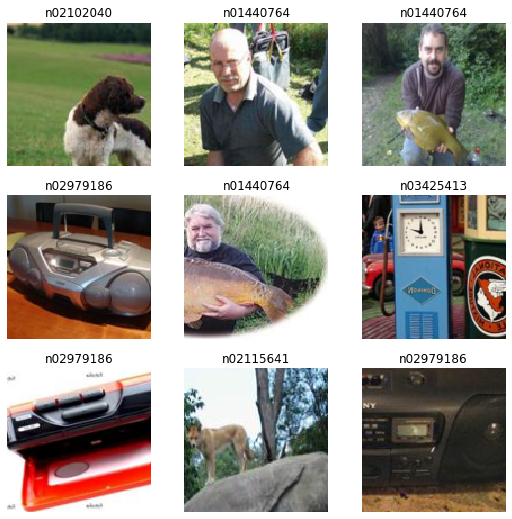

In [24]:
dbunch.show_batch()

### 5 Epochs

In [35]:
epochs = 5
runs = 1

In [36]:
for run in range(runs):
        print(f'Run: {run}')
        
#         aug = get_aug_pipe(size, min_scale=1.0, mult=1)
#         aug2 = get_aug_pipe(size, min_scale=0.3, mult=1)
#         cbs = SSCallback(BatchContrastiveLoss(XentContrastiveLoss(0.05)), size=size, aug_targ=aug, aug_pos=aug2, multi_loss=True)
#         ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 1024), nn.ReLU(), nn.Linear(1024, 64))
        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 1024))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
                pretrained=False,
                config={'custom_head':ch})#, cbs=cbs)
        
#         if fp16: learn = learn.to_fp16()
        learn.load(ss_name, strict=False)
        learn.model[1][-1] = nn.Linear(512, 20)
        
        learn.freeze()
#         learn.lr_find()
        learn.fit_flat_cos(epochs, 2e-2, wd=1e-3)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.027316,4.151337,0.000000,0.000509,00:13
1,1.601827,4.006378,0.000000,0.053703,00:13
2,1.466851,3.810458,0.001527,0.174090,00:13
3,1.372002,3.686779,0.008654,0.245355,00:15
4,1.316770,3.564845,0.012471,0.312802,00:15


- Run 1: 0.403156
- Run 2: 0.404429
- Run 3: 0.416645
- Run 4: 0.407228
- Run 5: 0.412064

Average: **40.87%**

### 20 Epochs

In [29]:
epochs = 20
runs = 3

In [33]:
for run in range(runs):
        print(f'Run: {run}')
#         ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 1024))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
                config={'custom_head':ch})#, cbs=cbs)
        
#         if fp16: learn = learn.to_fp16()
        learn.load(ss_name, strict=False)
        learn.model[1][-1] = nn.Linear(512, 20)
        
        learn.freeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Run: 0


KeyboardInterrupt: 

- Run 1: 0.610333
- Run 2: 0.618733
- Run 3: 0.605498

Average: **61.15%**

## 80 epochs

In [ ]:
epochs = 80
runs = 1

In [ ]:
for run in range(runs):
        print(f'Run: {run}')
        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
                config={'custom_head':ch})#, cbs=cbs)
        
        if dump: print(learn.model); exit()
#         if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
        learn.load(ss_name, strict=True)
        
        learn.freeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Accuracy: **62.18%**

### 200 epochs

In [ ]:
epochs = 200
runs = 1

In [ ]:
for run in range(runs):
        print(f'Run: {run}')
        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
                config={'custom_head':ch})#, cbs=cbs)
        
        if dump: print(learn.model); exit()
#         if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
        learn.load(ss_name, strict=True)
        
        learn.freeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Accuracy: **62.03%**